## 套件安裝

In [20]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['LSTM0429.ipynb',
 'data',
 'models',
 '0519KKTV.ipynb',
 'KKTV_LSTM0517.ipynb',
 'large0520.ipynb',
 'submit.csv',
 '0520KKTV.ipynb',
 '0520KKTV (22).ipynb']

In [21]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 資料長相（train有source, target / test只有source

## 加載資料

In [28]:
class TrainDataset(Dataset):
    # data loading
    def __init__(self, file_name_X, file_name_Y):
        X = pd.read_csv(file_name_X).drop(columns=['user_id']).to_numpy()
        X = X.reshape(X.shape[0], -1, 28) #變成每七天一個vector feature input_size=28, seq_len=37
        Y = pd.read_csv(file_name_Y)
        self.x = torch.from_numpy(X).to(torch.float32)
        self.y = torch.from_numpy(Y.drop(columns=['user_id']).to_numpy()).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 28

    # working for indexing
    def __getitem__(self, index):
        return self.x[index].reshape(-1, self.input_size), self.y[index] #符合lstm的輸入 (batch_first)
    def __len__(self):
        return self.n_samples

class TestDataset(Dataset):
    # data loading
    def __init__(self, file_name_X):
        X = pd.read_csv(file_name_X).drop(columns=['user_id']).to_numpy()
        X = X.reshape(X.shape[0], -1, 28) 
        self.x = torch.from_numpy(X).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 28

    # working for indexing
    def __getitem__(self, index):
        return self.x[index].reshape(-1, self.input_size) #符合lstm的輸入 seqlen再改
    def __len__(self):
        return self.n_samples

In [29]:
dataset_train = TrainDataset('./data/light_train_source_labels.csv', './data/light_train_target_labels.csv')
dataset_test = TestDataset('./data/light_test_source_labels.csv')

batch_size = 64 #符合test loader的因數
valid_ratio = 0.2
valid_set_size = int(valid_ratio * len(dataset_train)) #驗證集大小
train_set_size = len(dataset_train) - valid_set_size #訓練集大小
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [train_set_size, valid_set_size])

train_loader = DataLoader(dataset_train ,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size,shuffle=True, drop_last=False)

In [30]:
for _, (data, labels) in enumerate(train_loader):
  print(data.shape, labels.shape) #train:1036 columns, test:28 columns 
  break; ## seqlen根据数据特征数量调整，1036/28 = 37

torch.Size([64, 37, 28]) torch.Size([64, 28])


## 模型
https://blog.csdn.net/qq_40728805/article/details/103959254?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&utm_relevant_index=4
对于单层单向的LSTM， 其h_n最后一层输出h_n[-1,:,:]，和output最后一个时步的输出output[-1,:,:]相等。如果是分类任务的话，就可以把output[-1, :, :]或者output送到一个分类器分类。

比如：在做文字识别中，先对文本行图片提取feature，如shape为(B, 512, 1, 16)其中512是channel 维度，1是height，16是width，tensor处理为(B, 16, 512)或(16, B, 512)因为lstm要求输入是3D的，CNN的feature是4D的。

那这样，512就是input_size, 16就是seq_len
<br>
輸入LSTM:(batchsize,seqlen,inputsize) when batch_first=True 


https://discuss.pytorch.org/t/understanding-lstm-input/31110/5 LSTM input

In [31]:
class SimpleLSTM(nn.Module):

    def __init__(self):
        super(SimpleLSTM, self).__init__()

        self.input_size = 28 #一週七天*4 slot
        self.n_layers = 2 # LSTM的层数
        self.hidden_dim = 128 # 隐状态的维度，即LSTM输出的隐状态的维度为128
        self.output_size = 28 #輸出為每筆資料有28個欄位
        drop_prob=0.3 # dropout
        
        self.lstm = nn.LSTM(input_size = self.input_size, # 输入的维度
                            hidden_size = self.hidden_dim, # LSTM输出的hidden_state的维度
                            num_layers = self.n_layers, # LSTM的层数
                            dropout=drop_prob, 
                            batch_first=True # 第一个维度是否是batch_size
                           )
        self.fc = nn.Linear(in_features=self.hidden_dim, # 将LSTM的输出作为线性层的输入
                            out_features=self.output_size 
                            ) 
        self.sigmoid = nn.Sigmoid() # 线性层输出后，还需要过一下sigmoid
    
    def forward(self, x):
        """
        x: 本次的输入，其size为(batch_size, 37, 28)，37 為sequence len, 28為input_dim
        其中h和c的size都为(n_layers, batch_size, hidden_dim), 即(2, 64, 128)
        """
        h_0 = torch.randn(self.n_layers, batch_size, self.hidden_dim).to(device) #非雙向
        c_0 = torch.randn(self.n_layers, batch_size, self.hidden_dim).to(device)

        out, (ht,ct) = self.lstm(x, (h_0,c_0)) #out 為 (batch_size64, seqlen37, hidden_dim128) 
        #print('shape:', out.shape)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
 
        return out

## 訓練過程

In [32]:
def train(train_loader, valid_loader, model, model_name, epochs_num = 5):

  if not os.path.isdir('./models'):
      os.mkdir('./models') # Create directory of saving models.

  #criterion = nn.CrossEntropyLoss()
  criterion = nn.BCELoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
  loss_train = []
  loss_valid = []
  for epoch in range(epochs_num):
    model.train() # Set model to train mode
    train_pbar = tqdm(train_loader, position=0, leave=True)
    for datas, labels in train_pbar: #each batch 
      datas, labels = datas.to(device), labels.to(device) 
      optimizer.zero_grad() 
      outputs = model(datas) 
      loss = criterion(outputs, labels)  
      loss.backward() #反向傳播
      optimizer.step()
      loss_train.append(loss.detach().cpu().numpy())  
    #-----------------------validation----------------------#
    model.eval()
    with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
      for datas, labels in valid_loader:
        datas, labels = datas.to(device), labels.to(device) 
        outputs = model(datas) 
        loss = criterion(outputs, labels)  
        loss_valid.append(loss.detach().cpu().numpy())
  show_loss(loss_train, loss_valid)
  return model

def show_loss(train_loss, valid_loss):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(train_loss, color='blue', linewidth=2)
    axes[0].set_title('Training Loss', fontsize=16)
    axes[0].set_xlabel('iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot validation loss
    axes[1].plot(valid_loss, color='red', linewidth=2)
    axes[1].set_title('Validation Loss', fontsize=16)
    axes[1].set_xlabel('iteration', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()


## 真正訓練


  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

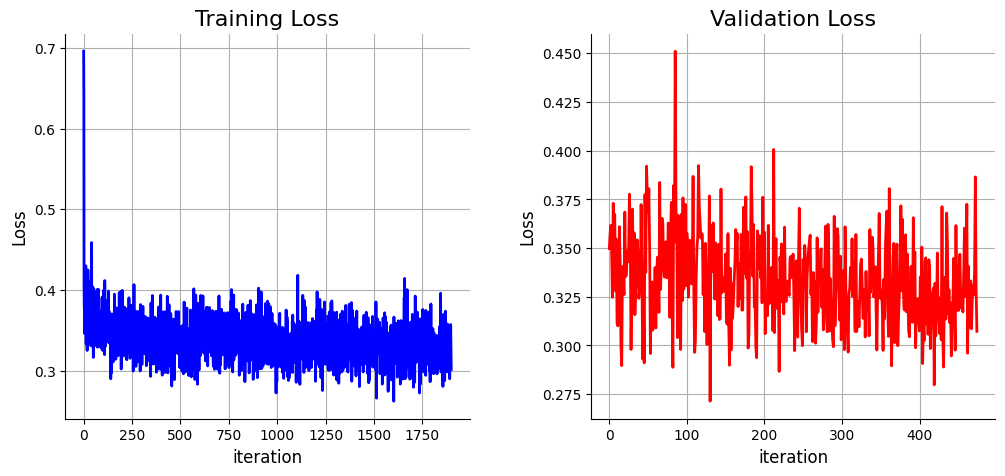

In [37]:
num_epoch = 5
model = SimpleLSTM().to(device)
model = train(train_loader, valid_loader, model, "SimpleLSTM", epochs_num = num_epoch)

## 產生輸出

In [38]:
model.eval()
output_list = []
with torch.no_grad():
  for datas in test_loader:
    datas = datas.to(device) 
    output_list.append(model(datas).cpu())

In [39]:
# print(len(output_list))
# print(len(output_list[1]))
# print(len(output_list[1][1]))
flatten_data = np.concatenate(output_list, axis=0)
showans = pd.DataFrame(flatten_data)
showans

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.154216,0.304771,0.282260,0.093768,0.201369,0.267523,0.283608,0.050169,0.075832,0.179492,...,0.223701,0.031709,0.090680,0.156124,0.198371,0.035813,0.088809,0.175267,0.171849,0.052051
1,0.124053,0.221275,0.038351,0.025564,0.187294,0.211218,0.027203,0.013418,0.031912,0.132521,...,0.022293,0.007580,0.051889,0.134550,0.019044,0.009652,0.050764,0.167656,0.027074,0.018555
2,0.309396,0.544474,0.062488,0.055250,0.376924,0.483699,0.033431,0.021215,0.052279,0.393876,...,0.022503,0.012284,0.069136,0.345093,0.018636,0.014377,0.081272,0.363517,0.033375,0.032536
3,0.596710,0.715513,0.120848,0.383616,0.686977,0.626944,0.090218,0.330275,0.334693,0.605934,...,0.082708,0.241285,0.351881,0.564442,0.053156,0.268951,0.368496,0.616869,0.079716,0.236134
4,0.405586,0.451913,0.038080,0.097383,0.437610,0.373952,0.023977,0.067996,0.413408,0.351731,...,0.019560,0.046428,0.437636,0.364370,0.017386,0.051591,0.415189,0.353519,0.030630,0.064592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.295470,0.518820,0.056715,0.048480,0.355833,0.457318,0.030054,0.018434,0.049019,0.368696,...,0.020340,0.010710,0.065142,0.321320,0.016893,0.012476,0.076762,0.342773,0.030396,0.029418
7612,0.147030,0.256364,0.033864,0.026044,0.209316,0.236750,0.022103,0.012771,0.031337,0.155128,...,0.017370,0.007045,0.048538,0.150431,0.014623,0.008909,0.049676,0.185189,0.022682,0.018464
7613,0.164061,0.374706,0.192264,0.044209,0.215416,0.342470,0.143100,0.017308,0.023679,0.233778,...,0.113101,0.010390,0.032141,0.193993,0.088467,0.012941,0.037769,0.219932,0.095641,0.029008
7614,0.540780,0.589138,0.039919,0.180956,0.590447,0.487030,0.024509,0.144989,0.530008,0.500537,...,0.022179,0.104066,0.548504,0.504444,0.017792,0.108975,0.534209,0.514495,0.034381,0.120294


In [40]:
sample = pd.read_csv("./data/sample.csv")
answer = sample
for i in range(1,29):
    answer.iloc[:,i] = showans.iloc[:, i-1]
display(answer)

<ipython-input-40-20a01fd229e5>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  answer.iloc[:,i] = showans.iloc[:, i-1]


,user_id,time_slot_0,time_slot_1,time_slot_2,time_slot_3,time_slot_4,time_slot_5,time_slot_6,time_slot_7,time_slot_8,...,time_slot_18,time_slot_19,time_slot_20,time_slot_21,time_slot_22,time_slot_23,time_slot_24,time_slot_25,time_slot_26,time_slot_27
0,30460,0.154216,0.304771,0.282260,0.093768,0.201369,0.267523,0.283608,0.050169,0.075832,...,0.223701,0.031709,0.090680,0.156124,0.198371,0.035813,0.088809,0.175267,0.171849,0.052051
1,30461,0.124053,0.221275,0.038351,0.025564,0.187294,0.211218,0.027203,0.013418,0.031912,...,0.022293,0.007580,0.051889,0.134550,0.019044,0.009652,0.050764,0.167656,0.027074,0.018555
2,30462,0.309396,0.544474,0.062488,0.055250,0.376924,0.483699,0.033431,0.021215,0.052279,...,0.022503,0.012284,0.069136,0.345093,0.018636,0.014377,0.081272,0.363517,0.033375,0.032536
3,30463,0.596710,0.715513,0.120848,0.383616,0.686977,0.626944,0.090218,0.330275,0.334693,...,0.082708,0.241285,0.351881,0.564442,0.053156,0.268951,0.368496,0.616869,0.079716,0.236134
4,30464,0.405586,0.451913,0.038080,0.097383,0.437610,0.373952,0.023977,0.067996,0.413408,...,0.019560,0.046428,0.437636,0.364370,0.017386,0.051591,0.415189,0.353519,0.030630,0.064592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,38071,0.295470,0.518820,0.056715,0.048480,0.355833,0.457318,0.030054,0.018434,0.049019,...,0.020340,0.010710,0.065142,0.321320,0.016893,0.012476,0.076762,0.342773,0.030396,0.029418
7612,38072,0.147030,0.256364,0.033864,0.026044,0.209316,0.236750,0.022103,0.012771,0.031337,...,0.017370,0.007045,0.048538,0.150431,0.014623,0.008909,0.049676,0.185189,0.022682,0.018464
7613,38073,0.164061,0.374706,0.192264,0.044209,0.215416,0.342470,0.143100,0.017308,0.023679,...,0.113101,0.010390,0.032141,0.193993,0.088467,0.012941,0.037769,0.219932,0.095641,0.029008
7614,38074,0.540780,0.589138,0.039919,0.180956,0.590447,0.487030,0.024509,0.144989,0.530008,...,0.022179,0.104066,0.548504,0.504444,0.017792,0.108975,0.534209,0.514495,0.034381,0.120294


In [41]:
answer.to_csv("submit.csv", index=False)